In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg
from scipy import interpolate

import PyQt5
from Classes import CrankNicolson,Hamiltonian, Math, EMField

%matplotlib notebook

<h3> Definición de los parámetros

In [15]:
Nx = 1000 #Número de puntos en el mallado espacial
Nt = 1000 #Número de puntos en el mallado temporal
x,h = np.linspace(-50,50,Nx,retstep=True) #Creamos un mallado espacial equiespaciado
a = 1.0 #Paramentro que define el ancho de la función gaussiana
#p0 = 0.0 
x0 = 0.0  #Centro de la función gaussiana a tiempo 0
psi = np.exp(-(x-x0)**2/(2*a**2)) #Funcíón Gaussiana
C = integrate.simps(np.conjugate(psi)*psi,x) #Constante de normalización
psin = psi/np.sqrt(C) #Normalizamos la función de onda
t,dt = np.linspace(0,50,Nt,retstep=True) #Mallado temporal equiespaciado

<h3> Representación de la de la densidad de probabiliad de la
onda de partida 

<IPython.core.display.Javascript object>


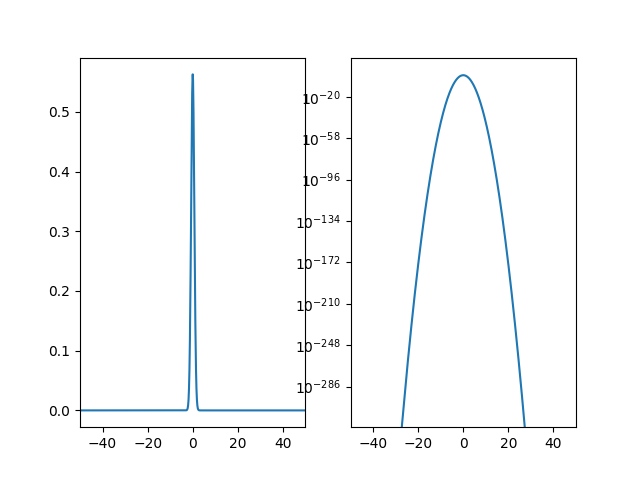

In [16]:
P = np.conjugate(psin)*psin #Densidad de probabilidad

fig = plt.figure();
axli = fig.add_subplot(121); #linear axis
axlo = fig.add_subplot(122); #logarithmic axis

axli.set_xlim(-50,50)
axlo.set_xlim(-50,50)

axli.plot(x,P);
axlo.plot(x,P);
axlo.set_yscale('log')
plt.show()

<h3> Evolución de la función de onda en ausencia de potencial y campo eléctrico

<IPython.core.display.Javascript object>


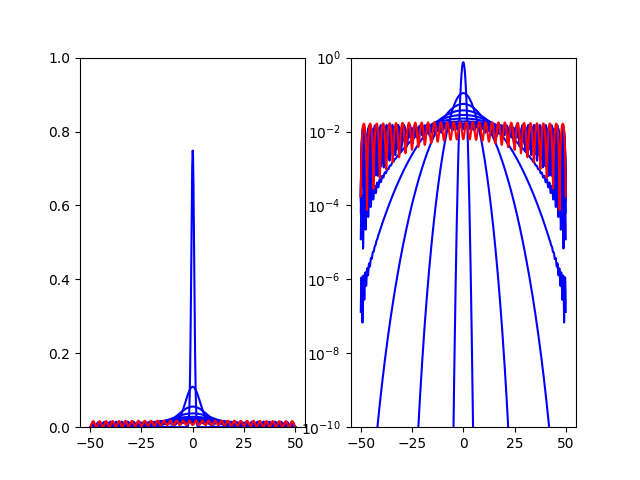

CPU times: user 1min 38s, sys: 51.1 s, total: 2min 29s
Wall time: 38.8 s


In [17]:
%%time 

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)


#Creamos el Hamiltoniano. En este caso desactivamos la opción del
#potencial Coulombiano y del potencial vector.
H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False) 

#Creamos el propagador con los parámetros deseados
Prop = CrankNicolson.Propagator(H,Nx,dt)

#En este caso partimos de la función de onda sin normalizar 
#para que sea más visual
psi0 = psi

for i in range(len(t)): #Se resolverá la propagación para cada instante de tiempo
    
    #Como se trata de un Hamiltoniano constante en el tiempo
    #no hará falta ejecutar Update() en cada iteración, tanto
    #en el Hamiltoniano como en el propagador
    
    psi1 = Prop.Propagate(psi0) #Propaga de psi0 a psi1 un dt
    norm = Math.Norm(psi1,x) #Calculamos la constate de normalización
    psi1 = psi1/np.sqrt(norm) #Normalizamos la función
    #CÓDIGO PARA GUARDAR CAPTURAS DE LAS GRÁFICAS
    #ax.title.set_text("Time: " + str(t[0][i]))
    #ax.plot(x,np.conjugate(psi1)*psi1,'b')
    #path = 'images/FPA/'+str(i)+'.png'
    #plt.savefig(path)
    #ax.clear()
    
    if (i%100 == 0): #Representaremos unicamente las iteraciones multiplos de 100
        axli.plot(x,np.conjugate(psi1)*psi1,'b');
        axlo.plot(x,np.conjugate(psi1)*psi1,'b');
    psi0 = psi1 #Movemos la función para la próxima iteración

axli.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final (lineal)
axlo.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final (logarítmico)
axlo.set_yscale('log')

plt.show()

<h3>Cálculo del estado fundamental del Hamiltoniano Coulombiano empleando lapropagación en tiempo imaginario

<IPython.core.display.Javascript object>


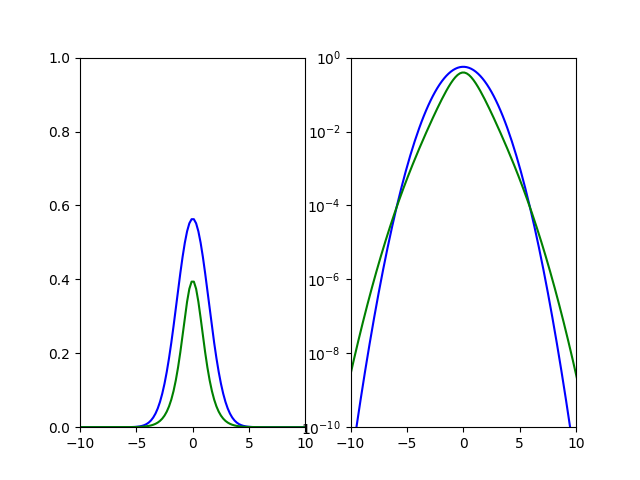

CPU times: user 29.8 s, sys: 17.5 s, total: 47.3 s
Wall time: 12.7 s


In [25]:
%%time

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)
axli.set_xlim(-10,10)
axlo.set_xlim(-10,10)

dt = -1j*0.01 #En este caso definimos dt de manera arbitraria.
              #Afectará al número de iteraciones para alcanzar la
              #resolución deseada
        
#Volvemos a crear el Hamiltoniano, esta vez con el potencial
#Coulombiano activado. Al cambiar el Hamiltoniano tambien
#reiniciamos el propagador
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False) 
Prop = CrankNicolson.Propagator(H,Nx,dt)

#La función de onda de partida en este caso será la función normalizada
psi0 = psin
ep0 = Math.EigenEnergy(psi0,H,x)
eps = 1 #Iniciamos el error inicial para entrar en el loop
delta = 1E-5 #Error en la energía desesa
count = 0 #contado de iteraciones

while (eps>delta):
    psi1 = Prop.Propagate(psi0) #Propagamos la función de onda un j*dt
    norm = Math.Norm(psi1,x) #Calculamos la constate de normalización
    psi1 = psi1/np.sqrt(norm) #Normalizamos la función
    
    ep1 = Math.EigenEnergy(psi1,H,x) #Calculamos la autoenergía asociada
    eps = abs(ep1-ep0) #Calculamos el error absoluto
    
    #Movemos la función y su energía para la próxima iteración
    ep0 = ep1
    psi0 = psi1
    count +=1 
    
#Graficamos la función inicial y la final (estado fundamental)
axli.plot(x,np.conjugate(psin)*psin,'b')
axli.plot(x,np.conjugate(psi1)*psi1,'g')
axlo.plot(x,np.conjugate(psin)*psin,'b')
axlo.plot(x,np.conjugate(psi1)*psi1,'g')
axlo.set_yscale('log')

psiG = psi1 #Guardamos la función de onda del estado fundamental

In [26]:
print("Número de iteraciones: " + str(count))
print("Energía del estado fundamental" + str(ep1))

Número de iteraciones: 254
Energía del estado fundamental(-0.6783327568514077+0j)


<h3>Propagación de la función de onda en presencia de un campo eléctrico

<IPython.core.display.Javascript object>


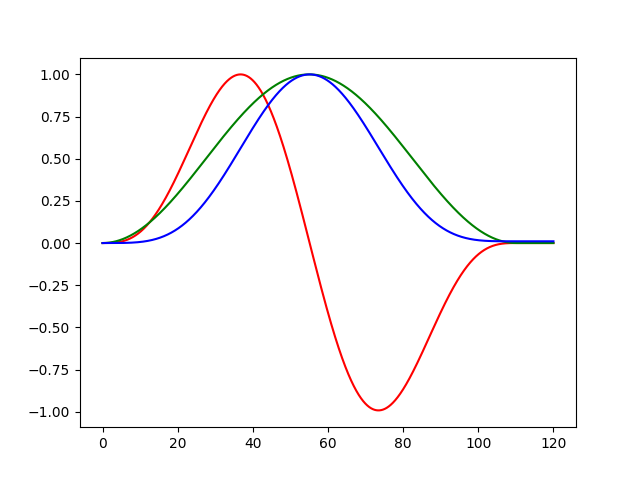

CPU times: user 9.81 s, sys: 458 ms, total: 10.3 s
Wall time: 9.33 s


In [27]:
%%time
t = np.linspace(0,120,10000)
fig = plt.figure();
ax = fig.add_subplot(111);
f = np.zeros(10000)
e = np.zeros(10000)
a = np.zeros(10000)
EM = EMField.EMField(0.067,0.057,110)
#e=EM.E(t)
for i in range(len((t))):
    a[i] = EM.A(t[i])
    e[i] = EM.E(t[i])
    f[i] = EM.f(t[i])
    
ax.plot(t,e/np.amax(e),'r')
ax.plot(t,f,'g')
ax.plot(t,a/np.amin(a),'b')

<IPython.core.display.Javascript object>


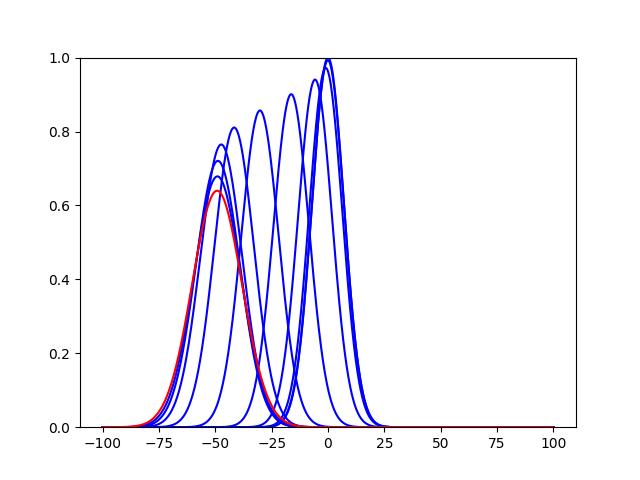

Calculando el potencial vector...
potencial vector calculado!
CPU times: user 2min 15s, sys: 1min 19s, total: 3min 35s
Wall time: 56.1 s


In [28]:
%%time
fig = plt.figure();
ax = fig.add_subplot(111);
#ax.set_xlim(-50,50)
ax.set_ylim(0,1.0)

a = 10.0 #Paramentro que define el ancho de la función gaussiana
#Redefinimos el mallado temporal para este caso
t,dt = np.linspace(0,120,Nt,retstep=True) 
#Redifinimos el mallado espacial para aumentarlo
x,h = np.linspace(-100,100,Nx,retstep=True) 
#Recalculamos la función Gaussiana
psi = np.exp(-np.power((x-x0),2)/(2*a**2)) #Funcíón Gaussiana


#Volvemos a crear tanto el Hamiltoniano como el propagador.
#Los datos del campo EM estan definidos internamente en la clase
#del Hamiltoniano
H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool = True)
Prop = CrankNicolson.Propagator(H,Nx,dt)

psi0 = psi #De nuevo partimos de la función de onda sin nomarlizar

for i in range(len(t)):
    H.Update(i) #Actualizamos el Hamiltoniano a la itreación i-ésima
    Prop.Update(H) #Actualizamos el porpagador con el nuevo Hamiltoniano
    
    psi1 = Prop.Propagate(psi0)  
    
    if (i%100== 0): #Rpresentamos solamente los multiplos de 100
        ax.plot(x,np.conjugate(psi1)*psi1,'b')
        
    psi0 = psi1 #Preparamos para la siguiente iteración

ax.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final

In [22]:
#t = np.linspace(0,2.5*15,1000)
#fig = plt.figure();
#ax = fig.add_subplot(111);
#f = np.zeros(1000)
#e = np.zeros(1000)
#a = np.zeros(1000)
#EM = EMField.EMField(2000,1,5,10,-100,5)

#for i in range(len((t))):
#    a[i] = EM.A(t[i])
#    e[i] = EM.E(t[i])
#    f[i] = EM.f(t[i])
    
#ax.plot(t,e/np.amax(e))
#ax.plot(t,f)
#ax.plot(t,a/np.amax(a))

<h3>Propagación con el potencial Coulombiano y con campo 
    eléctrico

In [30]:
%%time

#fig = plt.figure();
#ax = fig.add_subplot(111);
#ax.set_xlim(-50,50)
#ax.set_ylim(0,1.0)

#Redefinimos el mallado temporal para este caso
t,dt = np.linspace(0,120,Nt,retstep=True) 
#Redifinimos el mallado espacial para aumentarlo
x,h = np.linspace(-100,100,Nx,retstep=True) 
#Recalculamos la función Gaussiana
psi = np.exp(-(x-x0)**2/(2*a**2)) #Funcíón Gaussiana

#Creamos un array donde se almacenará la densida de probabilidad
PMatrix = np.zeros((Nt,Nx))

#Volvemos a crear tanto el Hamiltoniano como el propagador.
#Los datos del campo EM estan definidos internamente en la clase
#del Hamiltoniano
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool = True)
Prop = CrankNicolson.Propagator(H,Nx,dt)

psi0 = psi #De nuevo partimos de la función de onda sin nomarlizar

for i in range(len(t)):
    H.Update(i) #Actualizamos el Hamiltoniano a la itreación i-ésima
    Prop.Update(H) #Actualizamos el porpagador con el nuevo Hamiltoniano
    PMatrix[i] = np.array(np.conjugate(psi0)*psi0)
    
    psi1 = Prop.Propagate(psi0)  
    
    #if (i%100== 0): #Rpresentamos solamente los multiplos de 100
    #    ax.plot(x,np.conjugate(psi1)*psi1,'b')
    
    psi0 = psi1 #Preparamos para la siguiente iteración

#ax.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final

Calculando el potencial vector...
potencial vector calculado!


/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


CPU times: user 2min 1s, sys: 1min 2s, total: 3min 4s
Wall time: 48.4 s


<IPython.core.display.Javascript object>


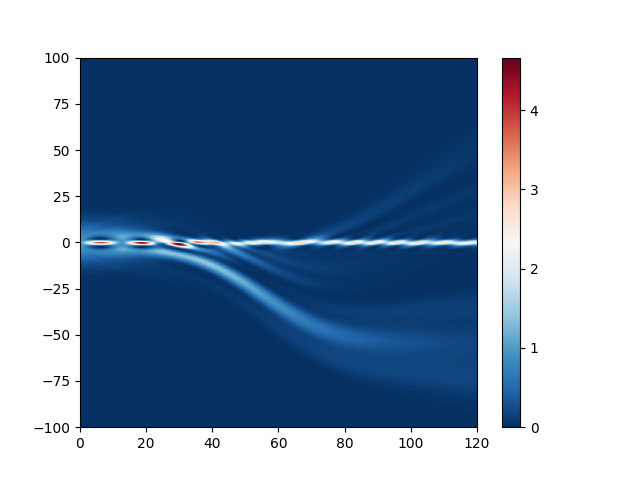

In [31]:
fig = plt.figure();
ax = fig.add_subplot(111);
c = ax.pcolormesh(t,x,np.transpose(PMatrix),cmap='RdBu_r')
fig.colorbar(c, ax=ax)
plt.show()

In [ ]:
PArray[0][500]